In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite.filters

#### Reproduce Fig. 1.11 from Rybicki & Lightman

In [3]:
c = 3e18 # A / s
h = 6.626e-27 # erg s
k_B = 1.381e-16 # erg / K

In [4]:
def b_lam(lam, T):
    # From R&L 1.52 (extra factor of 4 * np.pi comes from integrating over solid angle)
    num = (8 * np.pi * h * c ** 2) / lam ** 5 
    den = np.exp(h * c / (lam * k_B * T)) - 1
    return(num / den) # multiply by (1e8) ** 2 if converting from A^-2 to cm^-2

def redshift(lam, sed, z):
    a = 1 / (1 + z)
    return(lam / a, sed * a)

#### Blackbody spectrum with T = 6000 K

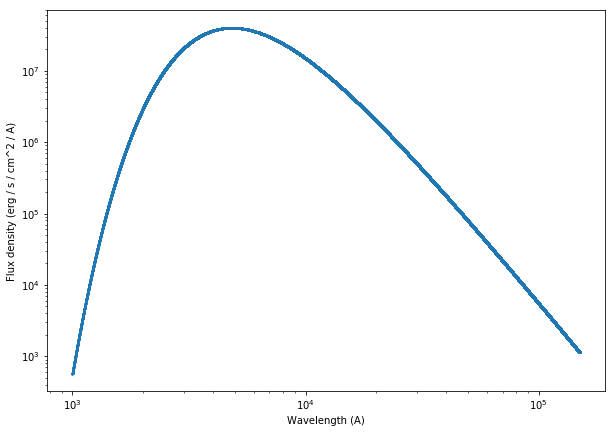

In [18]:
T = 6000
lam = np.arange(1000, 150000, .1)

plt.figure(figsize=(10,7))
plt.scatter(lam, b_lam(lam, T) * (1e16), s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux density (erg / s / cm^2 / A)')
plt.show()

#### Reproduce at different redshifts

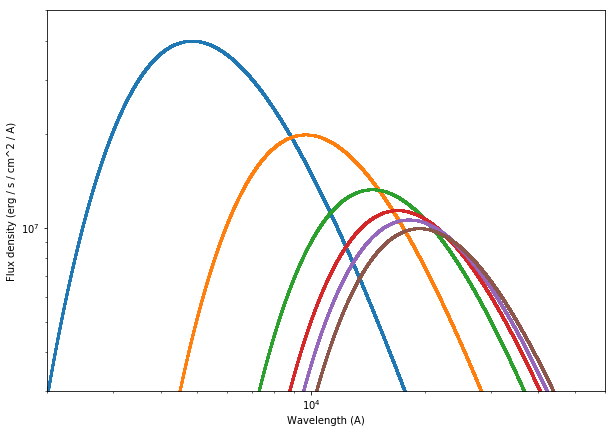

In [20]:
T = 6000
lam = np.arange(1000, 150000, .1)
sed = b_lam(lam, T) * 1e16

lam_1, sed_1 = redshift(lam, sed, z=1)
lam_2, sed_2 = redshift(lam, sed, z=2)
lam_25, sed_25 = redshift(lam, sed, z=2.5)
lam_275, sed_275 = redshift(lam, sed, z=2.75)
lam_3, sed_3 = redshift(lam, sed, z=3)

plt.figure(figsize=(10,7))
plt.scatter(lam, sed, s=1)
plt.scatter(lam_1, sed_1, s=1)
plt.scatter(lam_2, sed_2, s=1)
plt.scatter(lam_25, sed_25, s=1)
plt.scatter(lam_275, sed_275, s=1)
plt.scatter(lam_3, sed_3, s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux density (erg / s / cm^2 / A)')
plt.xlim(2000,60000)
plt.ylim(3e6,5e7)
plt.show()

#### Fix redshift, plot as a function of temperature

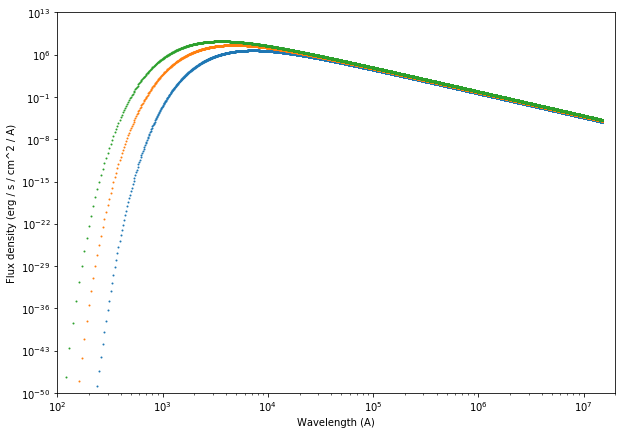

In [25]:
T1 = 4000 # red dwarf
T2 = 6000 # yellow dwarf
T3 = 8000
T4 = 10000 # blue star

lam = np.arange(100, 1.5e9, 10)

sed1 = b_lam(lam, T1) * 1e16
sed2 = b_lam(lam, T2) * 1e16
sed3 = b_lam(lam, T3) * 1e16
sed4 = b_lam(lam, T4) * 1e16

plt.figure(figsize=(10,7))
plt.scatter(lam, sed1, s=1)
plt.scatter(lam, sed2, s=1)
plt.scatter(lam, sed3, s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux density (erg / s / cm^2 / A)')
plt.xlim(0,2e7)
plt.ylim(1e-50,1e13)
plt.show()

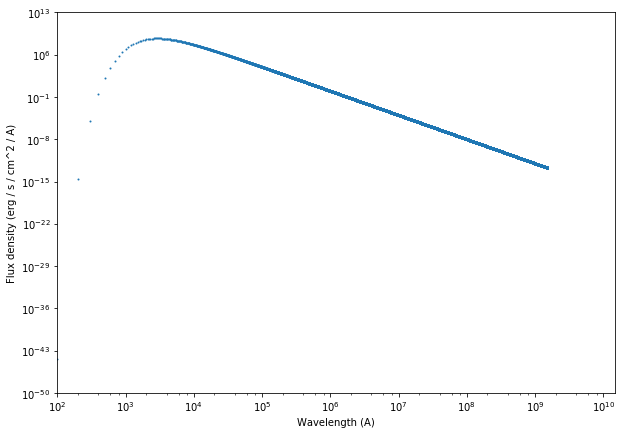

In [16]:
T4 = 10000 # blue star
lam = np.arange(100, 1.5e9, 100)
sed4 = b_lam(lam, T4) * 1e16


plt.figure(figsize=(10,7))
plt.scatter(lam, sed3, s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (A)')
plt.ylabel('Flux density (erg / s / cm^2 / A)')
plt.xlim(0,1.5e10)
plt.ylim(1e-50,1e13)
plt.show()

### Convolve filters with spectrum with speclite

http://speclite.readthedocs.io/en/latest/api/speclite.filters.FilterConvolution.html#speclite.filters.FilterConvolution

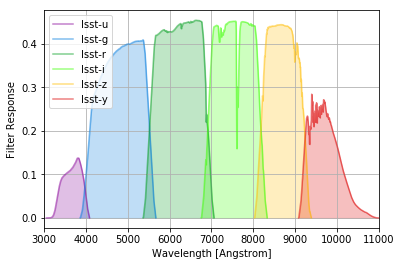

In [5]:
# LSST filters
lsst = speclite.filters.load_filters('lsst2016-*')
speclite.filters.plot_filters(
    lsst, wavelength_limits=(3000, 11000), legend_loc='upper left')

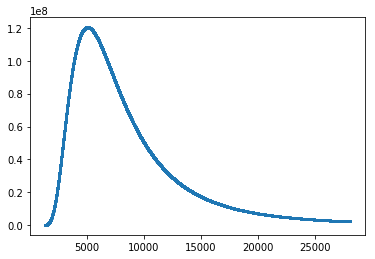

In [6]:
T = 8000
lam = np.arange(1000, 20000, 0.1)
sed = b_lam(lam, T) * 1e16

wlen, flux = redshift(lam, sed, 0.4)

plt.scatter(wlen, flux, s=1)
plt.show()

- generate blackbody spectrum, at temperature T and redshift z
- create a FilterConvolution object for each filter
- check that spectrum wavelengths cover wavelength response of filter
- if they don't pad spectrum
- convolve filter response with spectrum

In [6]:
lsst.names

['lsst-u', 'lsst-g', 'lsst-r', 'lsst-i', 'lsst-z', 'lsst-y']

In [7]:
def get_color(band1, band2, band3):
    band1_2 = -2.5 * np.log10(band1 / band2)
    band2_3 = -2.5 * np.log10(band2 / band3)
    return(band1_2, band2_3)

In [13]:
# pick a single temperature for now
T = 8000
step = 0.1
wlen_min = 1000
wlen_max = 20000

redshifts = np.arange(0.5, 3.6, 0.05)
nz = len(redshifts)
r_i = np.empty(nz)
i_z = np.copy(r_i)

lam_rest = np.arange(wlen_min, wlen_max, step)
sed_rest = b_lam(lam_rest, T) * 1e16


for jj, zz in enumerate(redshifts):
    
    wlen, flux = redshift(lam_rest, sed_rest, zz)
        
    # need to catch error when sed is redshifted and wlen range doesn't cover filter response range
    FilterConvR = speclite.filters.FilterConvolution(lsst[2], wlen) # samples the filter response at the sed wlen?
    FilterConvI = speclite.filters.FilterConvolution(lsst[3], wlen)
    FilterConvZ = speclite.filters.FilterConvolution(lsst[4], wlen)
    
    rconv = FilterConvR.__call__(flux)
    iconv = FilterConvI.__call__(flux)
    zconv = FilterConvZ.__call__(flux)
    
    r_i[jj], i_z[jj] = get_color(rconv, iconv, zconv)

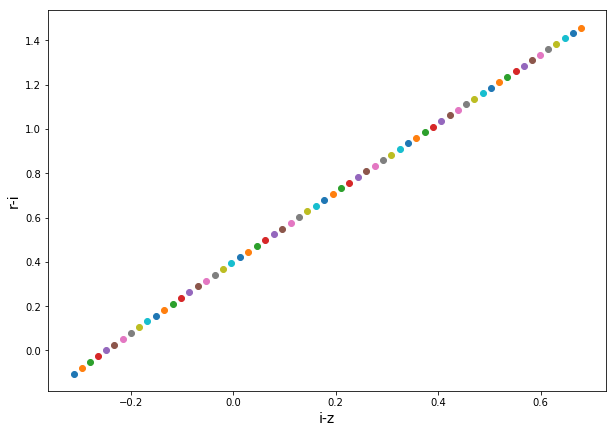

In [14]:
# color as a function of redshift is linear?
plt.figure(figsize=(10,7))
for k in range(nz):
    plt.plot(i_z[k], r_i[k], 'o-')
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.show()

In [14]:
step = 0.1
wlen_min = 1000
wlen_max = 20000

temperatures = np.array([4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4])
redshifts = np.arange(0.5, 3.6, 0.05)
nt = len(temperatures)
nz = len(redshifts)
r_i = np.empty((nt, nz))
i_z = np.copy(r_i)

lam_rest = np.arange(wlen_min, wlen_max, step)

for ii, tt in enumerate(temperatures):

    sed_rest = b_lam(lam_rest, tt) * 1e16
    
    for jj, zz in enumerate(redshifts):

        wlen, flux = redshift(lam_rest, sed_rest, zz)

        # need to catch error when sed is redshifted and wlen range doesn't cover filter response range
        FilterConvR = speclite.filters.FilterConvolution(lsst[2], wlen, photon_weighted=True)
        FilterConvI = speclite.filters.FilterConvolution(lsst[3], wlen, photon_weighted=True)
        FilterConvZ = speclite.filters.FilterConvolution(lsst[4], wlen, photon_weighted=True)

        rconv = FilterConvR.__call__(flux)
        iconv = FilterConvI.__call__(flux)
        zconv = FilterConvZ.__call__(flux)

        r_i[ii,jj], i_z[ii,jj] = get_color(rconv, iconv, zconv)

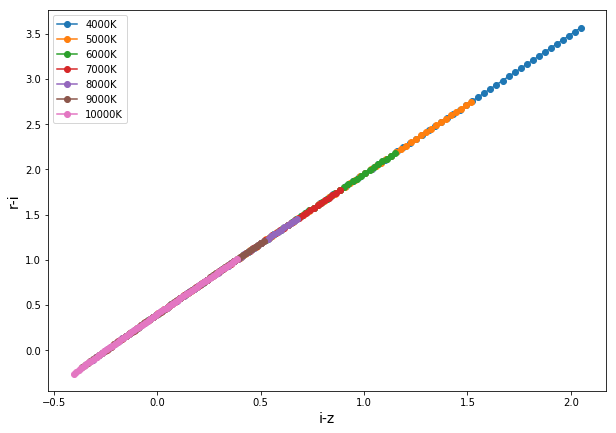

In [15]:
plt.figure(figsize=(10,7))
labels = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-', label=labels[k])
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()

In [21]:
def get_color(wlen_min, wlen_max, step, T, z):
    
    lam = np.arange(wlen_min, wlen_max, step)
    sed = b_lam(lam, T) * 1e16

    wlen, flux = redshift(lam, sed, z)

    # interpolate over wavelength range of the filter -- not sure I want to do this...
    rflux_interp = np.interp(x=lsst[2].wavelength, xp=wlen, fp=flux)
    iflux_interp = np.interp(x=lsst[3].wavelength, xp=wlen, fp=flux)
    zflux_interp = np.interp(x=lsst[4].wavelength, xp=wlen, fp=flux)
    
    rfilter_conv = speclite.filters.FilterConvolution(response=lsst[2], wavelength=wlen, photon_weighted=True)
    ifilter_conv = speclite.filters.FilterConvolution(response=lsst[3], wavelength=wlen, photon_weighted=True)
    zfilter_conv = speclite.filters.FilterConvolution(response=lsst[4], wavelength=wlen, photon_weighted=True)
    
    # rflux_conv wavelength and rflux_interp must be the same size
    rflux_conv = rfilter_conv.__call__(rflux_interp)
    iflux_conv = ifilter_conv.__call__(iflux_interp)
    zflux_conv = zfilter_conv.__call__(zflux_interp)
        
    r_i = -2.5 * np.log10(rflux_conv / iflux_conv)
    i_z = -2.5 * np.log10(iflux_conv / zflux_conv)
    
    return(r_i, i_z)

In [22]:
temperatures = np.array([4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4])
redshifts = np.arange(0.5, 3.6, 0.05)
nt = len(temperatures)
nz = len(redshifts)
r_i = np.empty((nt, nz))
i_z = np.copy(r_i)

for ii, tt in enumerate(temperatures):
    for jj, zz in enumerate(redshifts):
        r_i[ii, jj], i_z[ii, jj] = get_color(wlen_min=2000, wlen_max=20000, step=0.1, T=tt, z=zz)

AttributeError: 'FilterConvolution' object has no attribute 'shape'

In [73]:
temperatures = np.array([4e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4])
redshifts = np.arange(0.5, 3.6, 0.05)
nt = len(temperatures)
nz = len(redshifts)
r_i = np.empty(nz)
i_z = np.copy(r_i)


for jj, zz in enumerate(redshifts):
    r_i[jj], i_z[jj] = get_color(wlen_min=1000, wlen_max=20000, step=0.1, T=10000, z=zz)

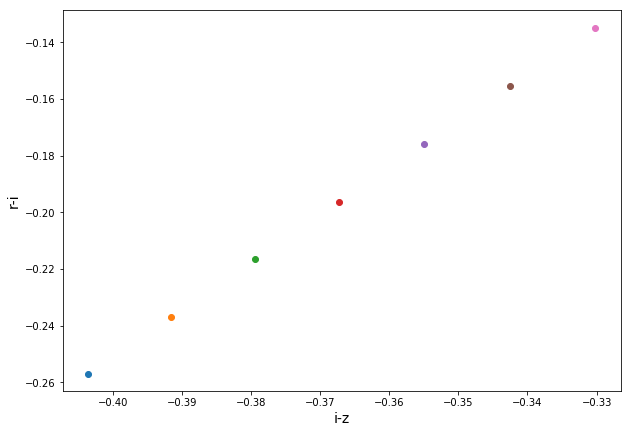

In [74]:
plt.figure(figsize=(10,7))
#label = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-')
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.show()

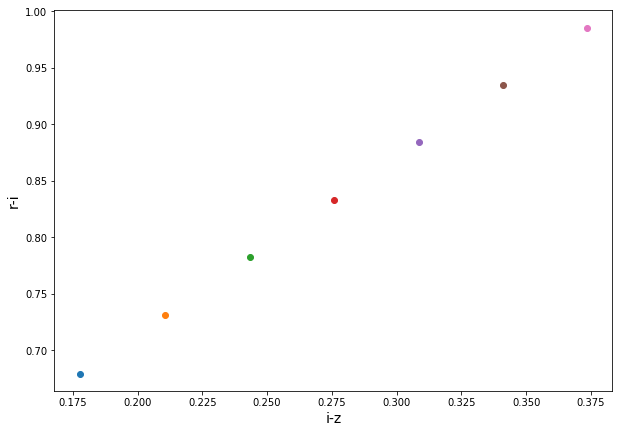

In [57]:
plt.figure(figsize=(10,7))
#label = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-')
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.show()

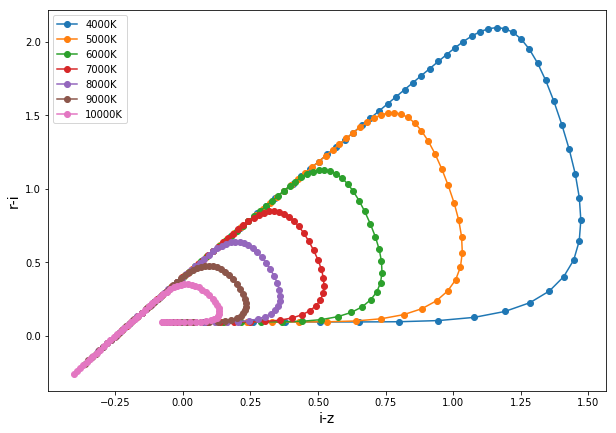

In [40]:
plt.figure(figsize=(10,7))
labels = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-', label=labels[k])
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()

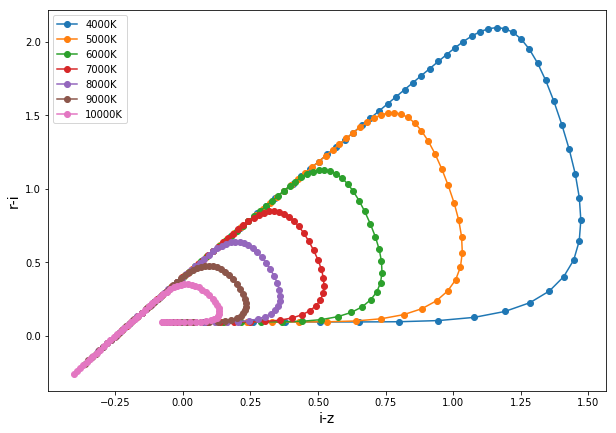

In [18]:
plt.figure(figsize=(10,7))
label = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-', label=label[k])
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()

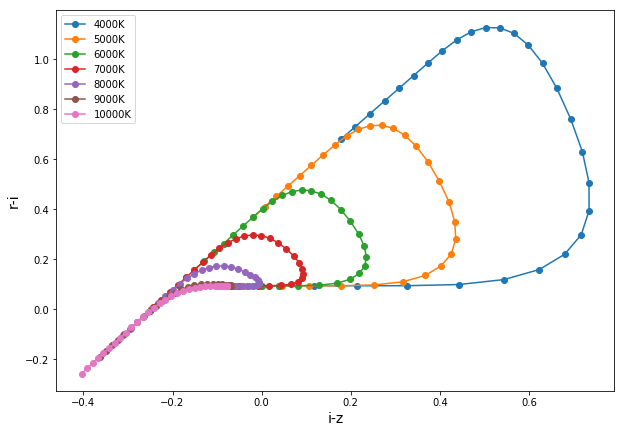

In [50]:
plt.figure(figsize=(10,7))
label = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(nt):
    plt.plot(i_z[k], r_i[k], 'o-', label=label[k])
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()

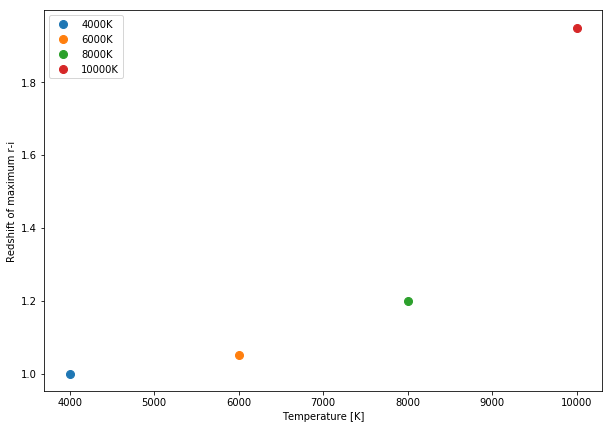

In [59]:
plt.figure(figsize=(10,7))
plt.plot(4000, redshifts[np.argmax(r_i[0])], '.', ms=16, label='4000K')
plt.plot(6000, redshifts[np.argmax(r_i[1])], '.', ms=16, label='6000K')
plt.plot(8000, redshifts[np.argmax(r_i[2])], '.', ms=16, label='8000K')
plt.plot(10000, redshifts[np.argmax(r_i[3])], '.', ms=16, label='10000K')
plt.xlabel('Temperature [K]')
plt.ylabel('Redshift of maximum r-i')
plt.legend(loc=2)
plt.show()

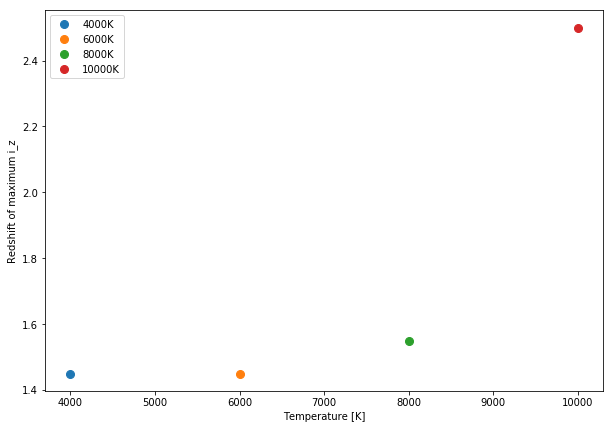

In [60]:
plt.figure(figsize=(10,7))
plt.plot(4000, redshifts[np.argmax(i_z[0])], '.', ms=16, label='4000K')
plt.plot(6000, redshifts[np.argmax(i_z[1])], '.', ms=16, label='6000K')
plt.plot(8000, redshifts[np.argmax(i_z[2])], '.', ms=16, label='8000K')
plt.plot(10000, redshifts[np.argmax(i_z[3])], '.', ms=16, label='10000K')
plt.xlabel('Temperature [K]')
plt.ylabel('Redshift of maximum i_z')
plt.legend(loc=2)
plt.show()

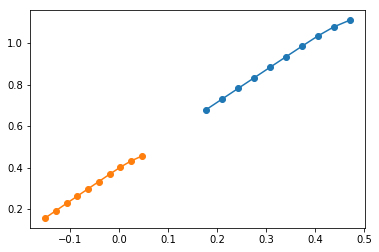

In [53]:
plt.plot(i_z[0][:10], r_i[0][:10], 'o-')
plt.plot(i_z[1][:10], r_i[1][:10], 'o-')